<span style = 'font-size:1.3em;line-height:1.5em'><b>1. </b>다음 조건을 만족하는 모델 MyNet Class를 작성하시오.</span>

- <span style = 'font-size:1.2em;line-height:1.5em'><b>Input data: </b>(Height, Width) = (224, 224)이며 색상이 있는(RGB 3 channel) Image가 input으로 들어간다. </span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>(Height, Width) = (224, 224)이며 색상이 있는(RGB 3 channel) Image가 input으로 들어간다. </span>


- <span style = 'font-size:1.2em;line-height:1.5em'><b>1st conv_batchnorm_relu_pool layers</b></span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>1st conv layer:</b> kernel_size = (3,3), channel수: 32, padding=1, padding_mode='replicate', stride=1</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>1st batch-norm:</b> num_features=32</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Activation function: </b> relu 활성화 함수</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>1st pool layer:</b> kernel_size = (2,2),  </span>


- <span style = 'font-size:1.2em;line-height:1.5em'><b>2nd conv_batchnorm_relu_pool layers</b></span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>2nd conv layer:</b> kernel_size = (3,3), channel수: 64, padding=1, padding_mode='replicate', stride=1</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>2nd batch-norm:</b> num_features=64</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Activation function: </b> relu 활성화 함수</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>2nd pool layer:</b> kernel_size = (2,2),  </span>


- <span style = 'font-size:1.2em;line-height:1.5em'><b>3rd conv_batchnorm_relu_pool layers</b></span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>3rd conv layer:</b> kernel_size = (3,3), channel수: 128, padding=1, padding_mode='replicate', stride=1</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>3rd batch-norm:</b> num_features=128</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Activation function: </b> relu 활성화 함수</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>3rd pool layer:</b> kernel_size = (2,2),  </span>


- <span style = 'font-size:1.2em;line-height:1.5em'><b>Flatten: </b> Dense layer(또는 FFNN)의 input으로 들어갈 수 있도록, tensor의 형태 변경</span>


- <span style = 'font-size:1.2em;line-height:1.5em'><b>1st dense layer:</b> in_features=<b>??</b>, out_features: 100</span>
- <span style = 'font-size:1.2em;line-height:1.5em'><b>Activation function: </b> relu 활성화 함수</span>
- <span style = 'font-size:1.2em;line-height:1.5em'><b>2nd dense layer</b> in_features=100, out_features=(class 갯수=2)  </span>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class MyNet(nn.Module):
    def __init__(self, in_channels, conv_hidden_channels=[32, 64, 128], hidden_layer=100, n_classes=2):
        super(MyNet, self).__init__()

        # 1st conv_batchnorm_relu_pool layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1, padding_mode='replicate', stride=(1,1))
        self.bn1 =nn.BatchNorm2d(conv_hidden_channels[0])
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        # 2nd conv_batchnorm_relu_pool layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, padding_mode='replicate', stride=(1,1))
        self.bn2 =nn.BatchNorm2d(conv_hidden_channels[1])
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        # 3rd conv_batchnorm_relu_pool layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1, padding_mode='replicate',stride=(1,1))
        self.bn3 =nn.BatchNorm2d(conv_hidden_channels[2])
        self.pool3 =nn.MaxPool2d(kernel_size=(2,2))

        # FFNN
        self.fc1 = nn.Linear(28*28*128,100, bias=True)
        self.fc2 = nn.Linear(100,2, bias=True )

    def _init_weights(self, submodule):
        if isinstance(submodule, nn.Conv2d):
            nn.init.xavier_normal_(submodule.weight)
            if submodule.bias is not None:
                submodule.bias.data.fill_(0.01)
        if isinstance(submodule, nn.Linear): # submodule이 nn.Linear에서 생성된 객체(혹은 인스턴스이면)
            nn.init.kaiming_normal_(submodule.weight) #해당 submodule의 weight는 He Initialization으로 초기화
            if submodule.bias is not None:
                submodule.bias.data.fill_(0.01) # 해당 submodule의 bias는 0.01로 초기화

    def forward(self, x):

        # 1st conv_batchnorm_relu_pool layers에서의 data_flow
        out = self.conv1(x)
        out = self.bn1(out)# 1st batchnorm
        out = F.relu(out)# 1st activation
        out = self.pool1(out)# 1st pooling

        print("After 1st conv layer, the shape of the result: ", out.shape)

        # 2nd conv_batchnorm_relu_pool layers에서의 data_flow
        out = self.conv2(out)# 2nd convolution
        out = self.bn2(out)# 2nd batchnorm
        out = F.relu(out)# 2nd activation
        out = self.pool2(out)# 2nd pooling

        print("After 2nd conv layer, the shape of the result: ", out.shape)

        # 3rd conv_batchnorm_relu_pool layers에서의 data_flow
        out = self.conv3(out)# 3rd convolution
        out = self.bn3(out)# 3rd batchnorm
        out = F.relu(out)# 3rd activation
        out = self.pool3(out)# 3rd pooling

        print("After 3rd conv layer, the shape of the result: ", out.shape)

        # Flatten
        out = out.reshape(-1, 28*28*128)# flatten (or view)

        print("After flatten, the shape of the result: ", out.shape)

        out = self.fc1(out)# 1st dense layer
        out = F.relu(out)# 1st activation
        out = self.fc2(out)# 2nd dense layer

        print("After dense layer, the shape of the result: ", out.shape)

        return out

## 다음과 같은 결과가 나와야 합니다.

In [32]:
x = torch.randn((16,3,224, 224)).to(device)

In [33]:
model = MyNet(in_channels=3).to(device)

In [34]:
out = model(x)

After 1st conv layer, the shape of the result:  torch.Size([16, 32, 112, 112])
After 2nd conv layer, the shape of the result:  torch.Size([16, 64, 56, 56])
After 3rd conv layer, the shape of the result:  torch.Size([16, 128, 28, 28])
After flatten, the shape of the result:  torch.Size([16, 100352])
After dense layer, the shape of the result:  torch.Size([16, 2])


<span style = 'font-size:1.3em;line-height:1.5em'><b>2. </b>실습 파일 '3.Image_Transformation_and_Augmentation(with torchvision).ipynb'에 있는 cats and dogs 이미지 파일을 활용하여 1번의 모델을 학습하는 코드를 작성하세요. Image transformation은 그림의 크기를 (224,224)로 resize하는 과정은 반드시 포함하고, 나머지는 원하는대로 해도 무관합니다. 또한, 모든 dataset을 training과 evaluate에 사용하세요.</span>

- <span style = 'font-size:1.2em;line-height:1.5em'><b>Hint 1: </b>실습 파일 '3.Image_Transformation_and_Augmentation(with torchvision).ipynb'과 '4.Use_custom_dataset.ipynb'에 있는 ImageFolder내용을 활용하여 CustomDataset을 만들고, 이를 DataLoader에 전달해서 mini-batch 생성기를 만드세요. </span>

- <span style = 'font-size:1.2em;line-height:1.5em'><b>Hint 2: </b>Train하는데 필요한 코드들은 '2.코드_정리.ipynb'에서 적절히 가지고 오시면 됩니다. 단, CustomDataset과 DataLoader부분은 Hint1의 내용으로 대체하시면 됩니다.</span>

In [35]:
import os, time, pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder

In [36]:
import urllib.request
import zipfile
import glob
import os
from PIL import Image, UnidentifiedImageError, ImageFile


# 이미지 Validation을 수행하고 Validate 여부를 return 합니다.
def validate_image(filepath):
    # image extensions
    image_extensions = ['.jpg', '.jpeg', '.jfif', '.pjpeg', '.pjp','.png', '.avif', '.gif']
    # 이미지 파일 확장자를 가진 경우
    if any(filepath.endswith(s) for s in image_extensions):
        try:
            # PIL.Image로 이미지 데이터를 로드하려고 시도합니다.
            img = Image.open(filepath).convert('RGB')
            img.load()
        except UnidentifiedImageError: # corrupt 된 이미지는 해당 에러를 출력합니다.
            print(f'Corrupted Image is found at: {filepath}')
            return False
        except (IOError, OSError): # Truncated (잘린) 이미지에 대한 에러를 출력합니다.
            print(f'Truncated Image is found at: {filepath}')
            return False
        else:
            return True
    else:
        print(f'File is not an image: {filepath}')
        return False

def download_dataset(download_url, folder, default_folder='tmp'):
    # 데이터셋을 다운로드 합니다.
    urllib.request.urlretrieve(download_url, 'datasets.zip')

    # 다운로드 후 tmp 폴더에 압축을 해제 합니다.
    local_zip = 'datasets.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall(f'{default_folder}/')
    zip_ref.close()

    # 잘린 이미지 Load 시 경고 출력 안함
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    # image 데이터셋 root 폴더
    root = f'{default_folder}/{folder}'

    dirs = os.listdir(root)

    for dir_ in dirs:
        folder_path = os.path.join(root, dir_)
        files = os.listdir(folder_path)

        images = [os.path.join(folder_path, f) for f in files]
        for img in images:
            valid = validate_image(img)
            if not valid:
                # corrupted 된 이미지 제거
                os.remove(img)

    folders = glob.glob(f'{default_folder}/{folder}/*')
    print(folders)
    return folders

In [37]:
download_datasets=download_dataset('https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip',
                 'PetImages')

Corrupted Image is found at: tmp/PetImages/Dog/11702.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


File is not an image: tmp/PetImages/Dog/Thumbs.db
Corrupted Image is found at: tmp/PetImages/Cat/666.jpg
File is not an image: tmp/PetImages/Cat/Thumbs.db
['tmp/PetImages/Dog', 'tmp/PetImages/Cat']


### 모델 정의하기

In [38]:
class MyNet(nn.Module):
    def __init__(self, in_channels, conv_hidden_channels=[32, 64, 128], hidden_layer=100, n_classes=2):
        super(MyNet, self).__init__()

        # 1st conv_batchnorm_relu_pool layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1, padding_mode='replicate', stride=(1,1))
        self.bn1 =nn.BatchNorm2d(conv_hidden_channels[0])
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        # 2nd conv_batchnorm_relu_pool layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, padding_mode='replicate', stride=(1,1))
        self.bn2 =nn.BatchNorm2d(conv_hidden_channels[1])
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        # 3rd conv_batchnorm_relu_pool layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1, padding_mode='replicate',stride=(1,1))
        self.bn3 =nn.BatchNorm2d(conv_hidden_channels[2])
        self.pool3 =nn.MaxPool2d(kernel_size=(2,2))

        # FFNN
        self.fc1 = nn.Linear(28*28*128,100, bias=True)
        self.fc2 = nn.Linear(100,2, bias=True )

    def _init_weights(self, submodule):
        if isinstance(submodule, nn.Conv2d):
            nn.init.xavier_normal_(submodule.weight)
            if submodule.bias is not None:
                submodule.bias.data.fill_(0.01)
        if isinstance(submodule, nn.Linear): # submodule이 nn.Linear에서 생성된 객체(혹은 인스턴스이면)
            nn.init.kaiming_normal_(submodule.weight) #해당 submodule의 weight는 He Initialization으로 초기화
            if submodule.bias is not None:
                submodule.bias.data.fill_(0.01) # 해당 submodule의 bias는 0.01로 초기화

    def forward(self, x):

        # 1st conv_batchnorm_relu_pool layers에서의 data_flow
        out = self.conv1(x)
        out = self.bn1(out)# 1st batchnorm
        out = F.relu(out)# 1st activation
        out = self.pool1(out)# 1st pooling

      #  print("After 1st conv layer, the shape of the result: ", out.shape)

        # 2nd conv_batchnorm_relu_pool layers에서의 data_flow
        out = self.conv2(out)# 2nd convolution
        out = self.bn2(out)# 2nd batchnorm
        out = F.relu(out)# 2nd activation
        out = self.pool2(out)# 2nd pooling

      #  print("After 2nd conv layer, the shape of the result: ", out.shape)

        # 3rd conv_batchnorm_relu_pool layers에서의 data_flow
        out = self.conv3(out)# 3rd convolution
        out = self.bn3(out)# 3rd batchnorm
        out = F.relu(out)# 3rd activation
        out = self.pool3(out)# 3rd pooling

    #    print("After 3rd conv layer, the shape of the result: ", out.shape)

        # Flatten
        out = out.reshape(-1, 28*28*128)# flatten (or view)

    #    print("After flatten, the shape of the result: ", out.shape)

        out = self.fc1(out)# 1st dense layer
        out = F.relu(out)# 1st activation
        out = self.fc2(out)# 2nd dense layer

     #   print("After dense layer, the shape of the result: ", out.shape)

        return out

### train() 함수

- <span style = 'font-size:1.2em;line-height:1.5em'>`train()`함수는 각 iteration마다 다음과 같이 진행됩니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 1.</b> batch_loader로부터 mini-batch x, y 데이터를 획득하고 원하는 device에 위치시키기</span>
        - <span style = 'font-size:1.0em;line-height:1.5em'> <b>n_data: </b>mini-batch data수, <b>1: </b>channel수(흑백이라서 단일 채널. 칼라 이미지(RGB)는 기본으로 3으로 설정됨) <b>28: </b>Width, <b>28: </b>height</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 2.</b> 지난 batch로부터 계산했던 gradient를 초기화(`zero_grad()`)</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 3.</b> 모델에 batch x를 입력하여 forward propagation</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 4.</b> loss function에 모델이 예측한 각 클래스에 속할 확률(`y_pred_prob`)과 실제 레이블 (`y`)을 넣어서 loss 계산</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 5.</b> Backpropagation으로 각 parameter의 gradient를 계산</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 6.</b> Gradient Descent로 parameter값 update</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 7.</b> `trn_loss` 변수에 mini-batch loss를 누적해서 합산</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 8.</b> 데이터 한 개당 평균 train loss 산출</span>

In [39]:
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    trn_loss = 0
    # 매 mini-batch train data마다 반복
    for i, (x, y) in enumerate(data_loader):
        # 1-(1): 모델에 입력하기 위해서 데이터의 형태 변환
        x = x.to(device) # x.shape: (batch_size,1, 28,28)
        y = y.to(device)

        # 1-(2): 기존에 계산된 gradient를 0으로 reset
        my_opt.zero_grad()

        # 1-(3): Forward Propagation
        y_pred_prob = model(x)

        # 1-(4): Loss Calculation
        loss = criterion(y_pred_prob, y)

        # 1-(5): Gradient Calculation(Backprop)
        loss.backward()

        # 1-(6): Update parameter
        optimizer.step()

        # 1-(7): trn_loss에 mini_batch loss를 누적해서 계산하기
        trn_loss += loss.item()

    # Step8. 데이터 한 개당 평균 train loss
    avg_trn_loss = trn_loss / len(data_loader.dataset)
    return avg_trn_loss

### evaluate()함수

- <span style = 'font-size:1.2em;line-height:1.5em'>`evaluate()`함수는 각 iteration마다 다음과 같이 진행됩니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 1.</b> batch_loader로부터 mini-batch x, y 데이터를 획득하고 원하는 device에 위치시키기</span>
        - <span style = 'font-size:1.0em;line-height:1.5em'> <b>n_data: </b>mini-batch data수, <b>1: </b>channel수(흑백이라서 단일 채널. 칼라 이미지(RGB)는 기본으로 3으로 설정됨) <b>28: </b>Width, <b>28: </b>height</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 2.</b> 모델에 batch x를 입력하여 forward propagation</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 3.</b> loss function에 모델이 예측한 각 클래스에 속할 확률(`y_pred_prob`)과 실제 레이블 (`y`)을 넣어서 loss 계산</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 4.</b> 모델이 예측하는 레이블을 산출 (with `torch.argmax()`)</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 5.</b> Minibatch의 실제 레이블(`y`)과 예측 레이블(`y_pred_label`)을 누적하여 저장</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 6.</b> `eval_loss` 변수에 mini-batch loss를 누적해서 합산</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>Step 7.</b> 데이터 한 개당 평균 evaluation loss와 accuracy 산출</span>

In [40]:
def evaluate(model, data_loader, optimizer, criterion, device):
    model.eval() # 모델을 평가모드로!
    eval_loss = 0

    results_pred = []
    results_real = []
    with torch.no_grad(): # evaluate()함수에는 단순 forward propagation만 할 뿐, gradient 계산 필요 X.
        for i, (x, y) in enumerate(data_loader):
            # Step 1. mini-batch에서 x,y 데이터를 얻고, 원하는 device에 위치시키기
            x = x.to(device) # x.shape: [batch_size,28,28] -> [batch_size, 784]
            y = y.to(device)

            # Step 2. Forward Propagation
            y_pred_prob = model(x)

            # Step 3. Loss Calculation
            loss = criterion(y_pred_prob, y)

            # Step 4. Predict label
            y_pred_label = torch.argmax(y_pred_prob, dim=1)

            # Step 5. Save real and predicte label
            results_pred.extend(y_pred_label.detach().cpu().numpy())
            results_real.extend(y.detach().cpu().numpy())

            # Step 6. eval_loss변수에 mini-batch loss를 누적해서 합산
            eval_loss += loss.item()

    # Step 7. 데이터 한 개당 평균 eval_loss와 accuracy구하기
    avg_eval_loss = eval_loss / len(data_loader.dataset)
    results_pred = np.array(results_pred)
    results_real = np.array(results_real)
    accuracy = np.sum(results_pred == results_real) / len(results_real)

    return avg_eval_loss, accuracy

### 매 Epoch에 드는 시간 측정

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Custom Dataset 및 DataLoader생성하기

In [42]:
image_transform =transforms.Compose([transforms.Resize((224,224)),
                              transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET,
                                                     interpolation=transforms.InterpolationMode.BILINEAR),
                              transforms.ToTensor()])#여기에 코드를 작성하세요.

transform_dset = ImageFolder(root='tmp/PetImages',
                              transform=image_transform)# 여기에 코드를 작성하세요.

In [43]:
transform_dset

Dataset ImageFolder
    Number of datapoints: 24998
    Root location: tmp/PetImages
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
               ToTensor()
           )

In [ ]:
transform_dset.samples

In [45]:
from torch.utils.data import random_split

ratio = 0.8

trn_size=int(ratio * len(transform_dset))
tst_size=len(transform_dset)-trn_size

print(f'total:{len(transform_dset)}\ntrn_size: {trn_size}\ntst_size:{tst_size}')

trn_data, tst_data = random_split(transform_dset, [trn_size, tst_size])

total:24998
trn_size: 19998
tst_size:5000


In [46]:
trn_loader = DataLoader(trn_data, batch_size=4, shuffle=True, drop_last=False, num_workers=1)# 여기에 코드를 작성하세요.
val_loader = DataLoader(tst_data, batch_size=4, shuffle=False, drop_last=False, num_workers=1)# 여기에 코드를 작성하세요.

In [47]:
image_transform, labels = next(iter(trn_loader))
print(image_transform.shape)

torch.Size([4, 3, 224, 224])


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
tmp = np.array(image_transform[0].permute(1,2,0))

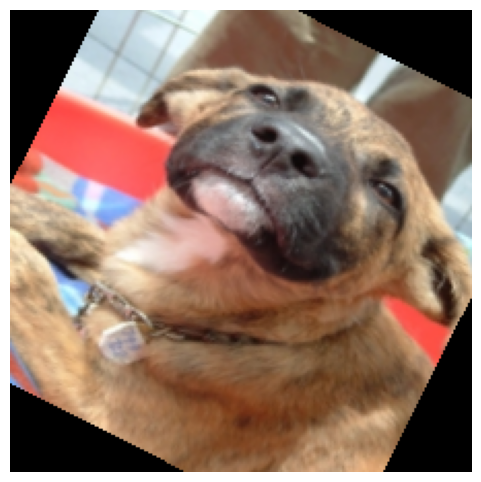

In [50]:
plt.figure(figsize=(6, 6))
# permute로 이미지의 shape를 다음과 같이 변경합니다
# (height, width, channel)
plt.imshow(tmp)
plt.grid(False)
plt.axis('off')
plt.show()

In [51]:
tmp.shape

(224, 224, 3)

In [53]:
transform_dset.class_to_idx

{'Cat': 0, 'Dog': 1}

In [54]:
images, labels = next(iter(trn_loader))
images.shape, labels.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

### 나머지 필요한 parameter 정의하기

- <span style = 'font-size:1.2em;line-height:1.5em'>모델 객체 생성하기</span>

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
model = MyNet(in_channels=3)
model = model.to(device)

In [57]:
model

MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

- <span style = 'font-size:1.2em;line-height:1.5em'>학습한 모델을 저장할 directory 생성하기</span>

In [58]:
save_dir = 'models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

- <span style = 'font-size:1.2em;line-height:1.5em'>필요한 hyperparameter값 설정하기</span>

In [59]:
N_EPOCHS = 10
LR = 2e-4

- <span style = 'font-size:1.2em;line-height:1.5em'>loss함수 정의하기</span>

In [60]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

- <span style = 'font-size:1.2em;line-height:1.5em'>optimizer 생성하기</span>

In [61]:
my_opt = optim.Adam(model.parameters(), lr = LR)

- <span style = 'font-size:1.2em;line-height:1.5em'>trn_data에 대해서 train()함수를, tst_data에 대해서 evaluate()함수를 반복적으로 호출하면서 모델을 학습</span>
    - <span style = 'font-size:1.2em;line-height:1.5em'>매 epoch마다 학습이 마무리되면, 모델 평가를 진행한다</span>

In [62]:
best_val_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    trn_loss = train(model=model,
                     data_loader=trn_loader,
                     optimizer=my_opt,
                     criterion=loss_func,
                     device=device)
    val_loss, accuracy = evaluate(model=model,
                                  data_loader=val_loader,
                                  optimizer=my_opt,
                                  criterion=loss_func,
                                  device=device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{save_dir}/my_model10.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {trn_loss:.3f} | Test Loss: {val_loss:.3f} | Test Acc: {100*accuracy:.3f}% ')

Epoch: 01 | Time: 2m 39s
	Train Loss: 0.641 | Test Loss: 0.553 | Test Acc: 71.600% 
Epoch: 02 | Time: 2m 41s
	Train Loss: 0.536 | Test Loss: 0.568 | Test Acc: 70.420% 
Epoch: 03 | Time: 2m 36s
	Train Loss: 0.488 | Test Loss: 0.520 | Test Acc: 74.720% 
Epoch: 04 | Time: 2m 33s
	Train Loss: 0.469 | Test Loss: 0.496 | Test Acc: 75.360% 
Epoch: 05 | Time: 2m 34s
	Train Loss: 0.448 | Test Loss: 0.493 | Test Acc: 76.780% 
Epoch: 06 | Time: 2m 34s
	Train Loss: 0.434 | Test Loss: 0.453 | Test Acc: 78.660% 
Epoch: 07 | Time: 2m 33s
	Train Loss: 0.420 | Test Loss: 0.467 | Test Acc: 77.340% 
Epoch: 08 | Time: 2m 35s
	Train Loss: 0.405 | Test Loss: 0.456 | Test Acc: 78.520% 
Epoch: 09 | Time: 2m 37s
	Train Loss: 0.391 | Test Loss: 0.443 | Test Acc: 78.640% 
Epoch: 10 | Time: 2m 36s
	Train Loss: 0.378 | Test Loss: 0.434 | Test Acc: 79.720% 
